# EX4b: Circle Hough transform
In the ex. we will implement step by step circle hough transform.
Follow the code and fill in the missing parts



In [14]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess 
    subprocess.call('apt-get install subversion'.split())
    subprocess.call('svn export https://github.com/YoniChechik/AI_is_Math/trunk/c_04b_hough_transform/ex4b/circles.bmp'.split())



In [15]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

figsize = (10, 10)



## Import an image


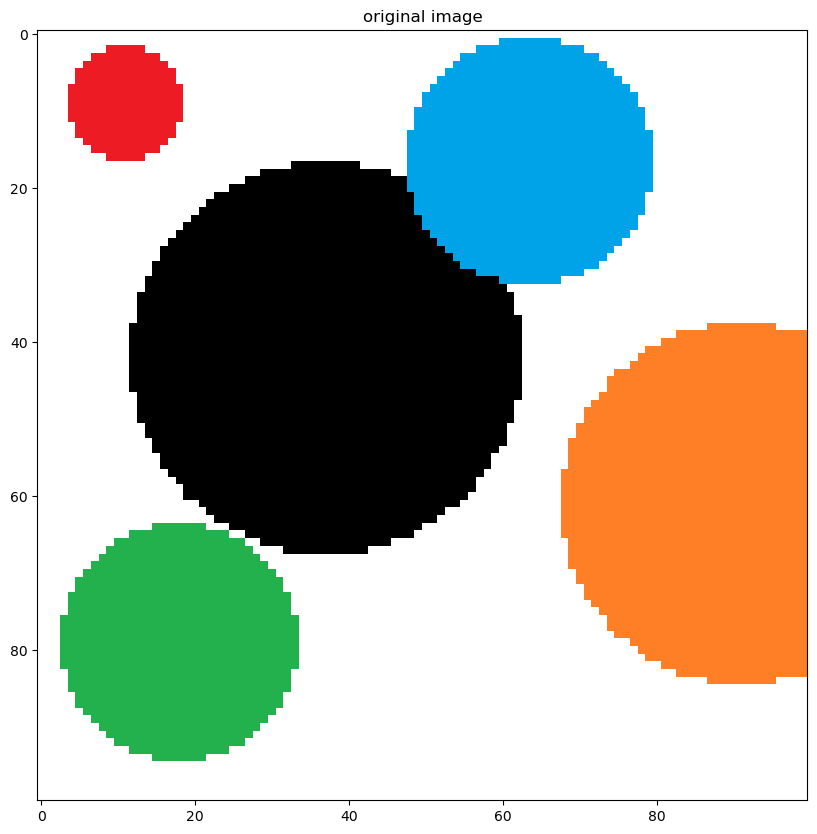

In [16]:
im3 = cv2.imread("circles.bmp")
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

im = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=figsize)
plt.imshow(im3, cmap='gray', vmin=0, vmax=255)
plt.title("original image")
plt.show()




## Find edges of an image using Canny


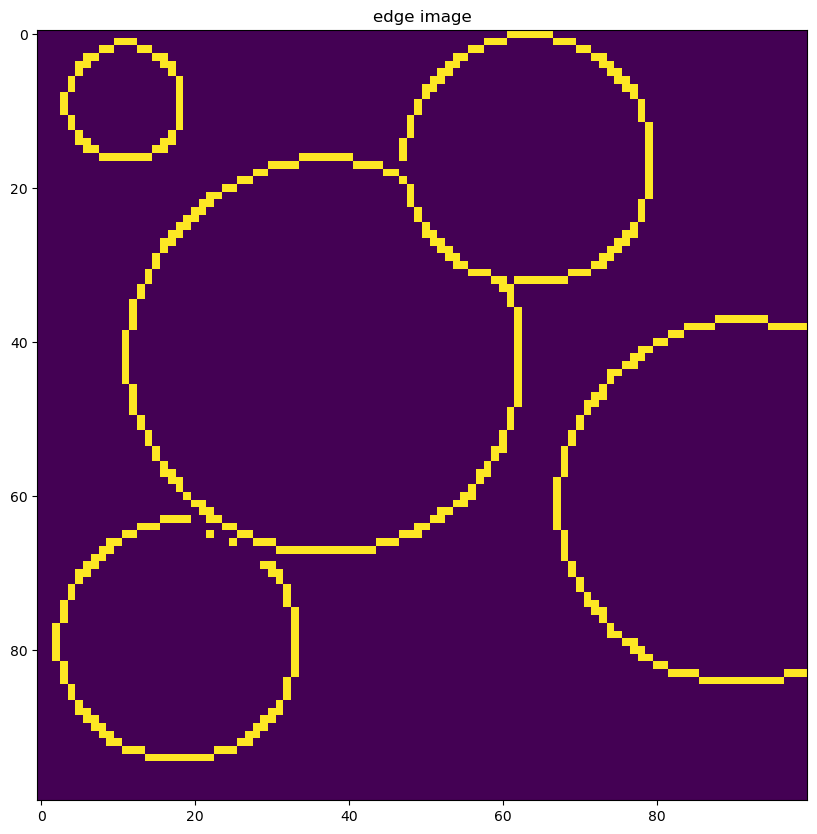

In [17]:
# TODO: Canny edge detection of image 
mag_im = cv2.Canny(im, 50, 400)
plt.figure(figsize=figsize)
plt.imshow(mag_im)
plt.title("edge image")
plt.show()



## Initialize accumulation matrix


In [18]:
# TODO: state parameters for accumulation matrix
# What parameters a circle accumulation matrix needs?
# Hint: **very similar to what we did in line Hough transform... take a reference from this code**
# If you need more clues, read the rest of the code.
# (6-8 lines- but all are similar to each other)
#
# Another hint- when building r vector- use this:
rmin = 0
rmax = 30
r_step = 1
r = np.arange(rmin,rmax+1,r_step)
#~~~FILL REST HERE~~~
a_step = 1
a = np.arange(0,mag_im.shape[1],a_step)
b_step = 1
b = np.arange(0,mag_im.shape[0],b_step)
# TODO: init accumulation matrix (one line)
# watch out of the order- which comes first? rows or cols?
acc_mat = np.zeros((b.shape[0],a.shape[0],r.shape[0]))



## Fill accumulation matrix


In [19]:
# get indices of edges
# HINT: you can debug faster if you'll use only a small part of the image. remember to comment it back later
# mag_im = mag_im[0:20,0:20]
edge_inds = np.argwhere(mag_im > 0)

# run on all a,b and edge indices and find corresponding R
for yx in edge_inds:
    x = yx[1]
    y = yx[0]
    #print("running on edge:"+str(yx)+"...")
    
    for a_ind, a0 in enumerate(a):
        for b_ind, b0 in enumerate(b):

            # TODO: find best corresponding r0 (1 line)
            r0 = np.sqrt((a0-x)**2 + (b0-y)**2)
            # something to make it faster
            if r0 > rmax:
                continue

            #TODO: find best index in r dimension (1 line)
            r_ind = np.argmin(np.abs(r - r0))

            # TODO: update accumulation matrix (1 line)            
            acc_mat[b_ind, a_ind,r_ind] +=  1   


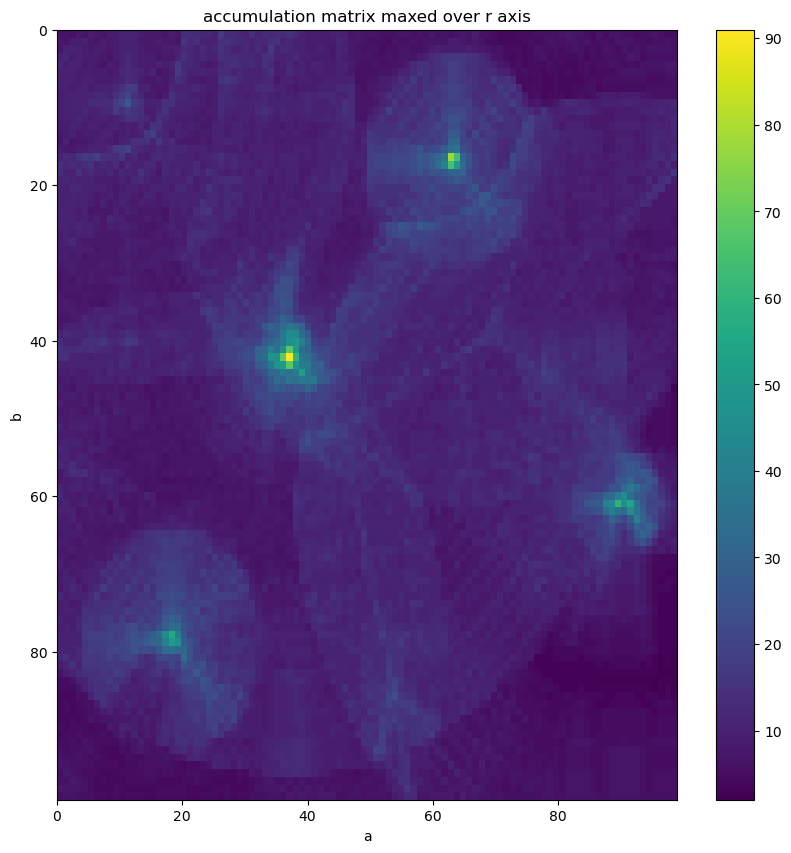

In [20]:
plt.figure(figsize=figsize)
plt.imshow(np.max(acc_mat, axis=2), extent=[b.min(), b.max(), a.max(), a.min()],aspect='auto')
plt.xlabel('a')
plt.ylabel('b')
plt.title('accumulation matrix maxed over r axis')
plt.colorbar()
plt.show()



## Threshold accumulation matrix


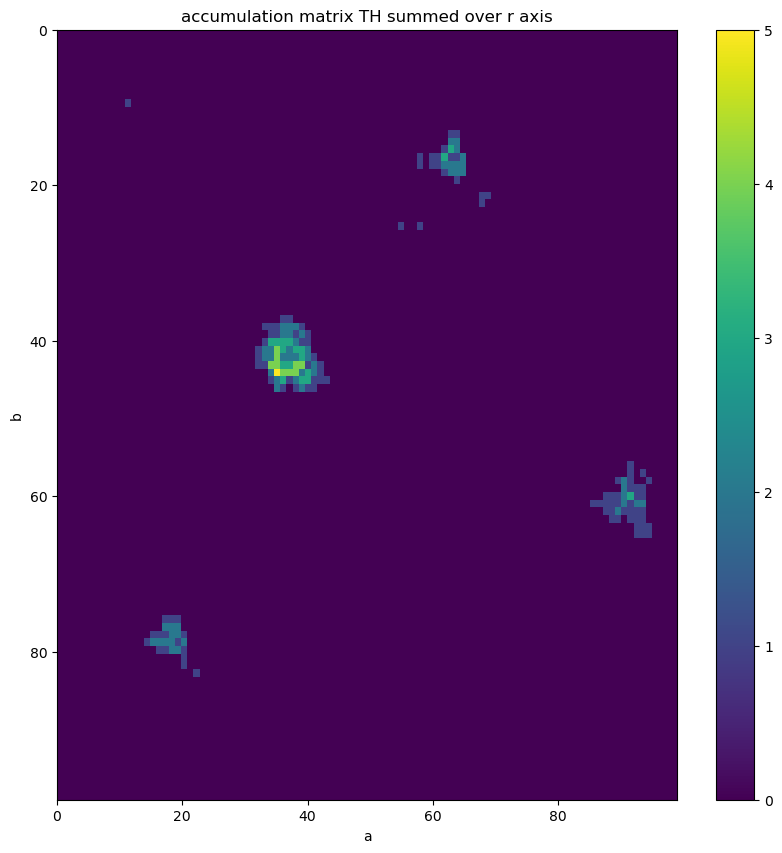

In [21]:
TH =  25
acc_mat_th = acc_mat > TH

plt.figure(figsize=figsize)
plt.imshow(np.sum(acc_mat_th, axis=2), extent=[b.min(), b.max(), a.max(), a.min()],aspect='auto')
plt.xlabel('a')
plt.ylabel('b')
plt.title('accumulation matrix TH summed over r axis')
plt.colorbar()
plt.show()


## Min distance
This is a new feature that deals with noise in the accumulation matrix.
1. Search in the neighborhood of each above TH bin for other above TH bins
2. compare the two and delete the less important one


In [22]:
edge_inds = np.argwhere(acc_mat_th > 0)

min_dist = 15
acc_mat_th_dist = acc_mat_th.copy()
# run on all above TH bins
for i in range(edge_inds.shape[0]):
    b0, a0, r0 = edge_inds[i]
    # search in all other above TH bins
    for j in range(i+1, edge_inds.shape[0]):
        b1, a1, r1 = edge_inds[j]
        
        # if the two above are neighbors (below min_dist) - delete the less important
        if ((r0-r1)*r_step)**2+((a0-a1)*a_step)**2+((b0-b1)*b_step)**2 < min_dist**2:
            if acc_mat[b0, a0, r0] >= acc_mat[b1, a1, r1]:
                #TODO: one line fill here
                acc_mat_th_dist[b1, a1, r1] = 0

            else:
                #TODO: one line fill here
                acc_mat_th_dist[b0, a0, r0] = 0 


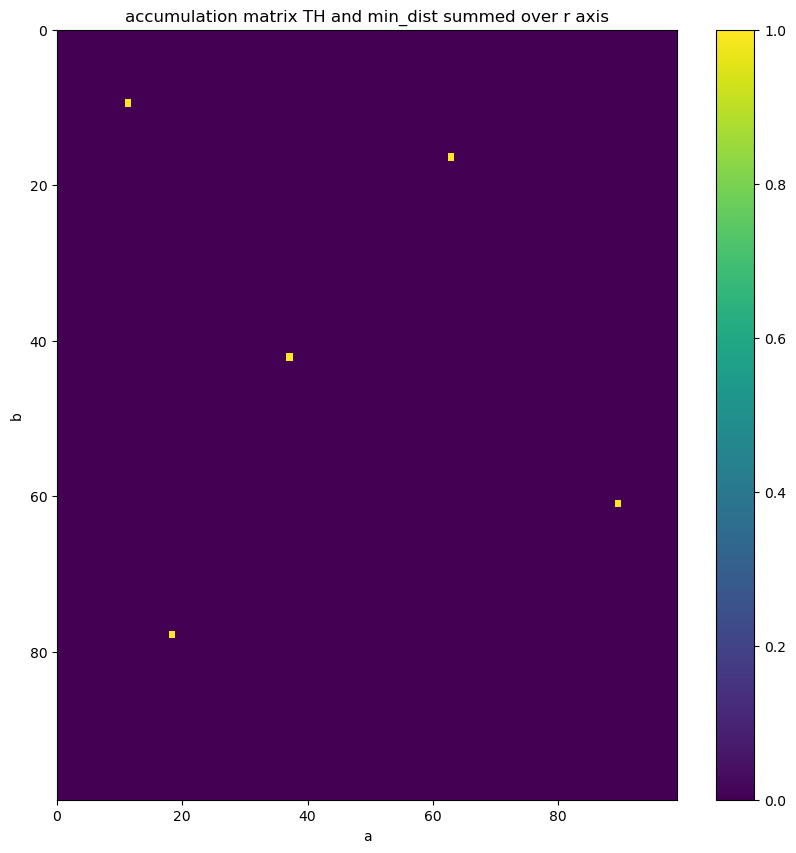

In [23]:
plt.figure(figsize=figsize)
plt.imshow(np.sum(acc_mat_th_dist, axis=2), extent=[b.min(), b.max(), a.max(), a.min()],aspect='auto')
plt.xlabel('a')
plt.ylabel('b')
plt.title('accumulation matrix TH and min_dist summed over r axis')
plt.colorbar()
plt.show()



## Plot circles found by hough


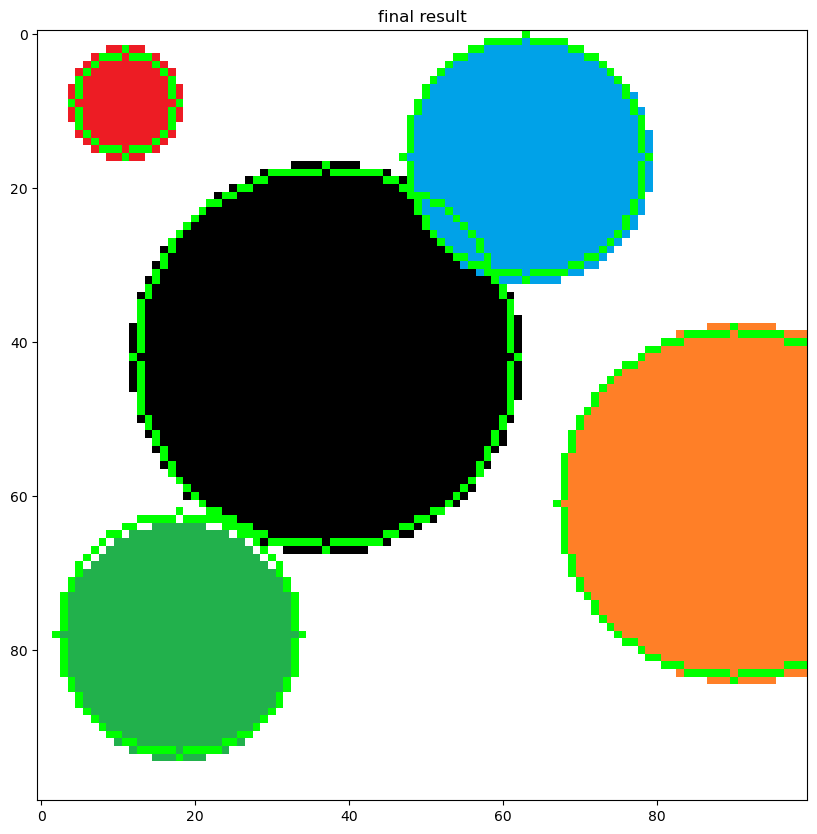

In [24]:
# get indices of acc_mat_th_dist
edge_inds = np.argwhere(acc_mat_th_dist > 0)

res = im3.copy()
for b_ind, a_ind, r_ind in edge_inds:
    r0 = r[r_ind]
    a0 = a[a_ind]
    b0 = b[b_ind]

    # draw the outer circle
    res = cv2.circle(res, (a0, b0), r0, (0, 255, 0), 1)

plt.figure(figsize=figsize)
plt.imshow(res)
plt.title("final result")
plt.show()


## Comparison to cv2.HoughCircles


(100, 100, 3)
[63.5 16.5 16. ]
[37.5 41.5 25.6]
[90.5 60.5 23.6]
[19.5 78.5 15.8]
[10.5  9.5  7. ]


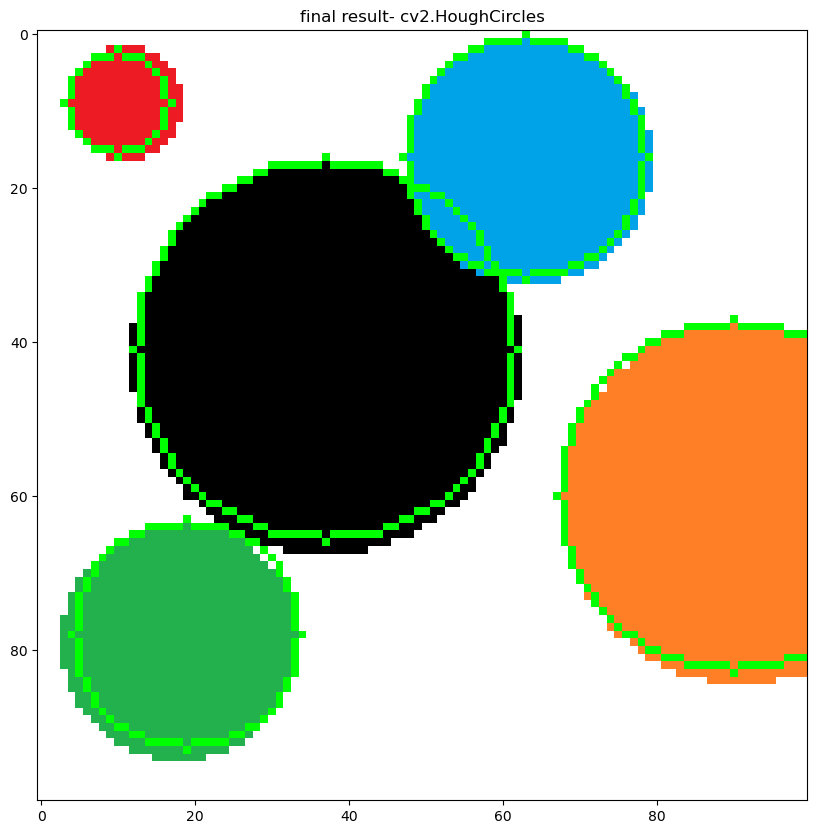

In [25]:
res = im3.copy()

# explanation can ve found here:
# https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html
circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 1,
                           10, param1=100, param2=8, minRadius=5, maxRadius=30)
circles = circles[0]
for circle in circles:
    print(circle)

    # draw the outer circle
    a , b , r = circle.flatten()
    res = cv2.circle(res, (int(a), int(b)), int(r), (0, 255, 0), 1)

plt.figure(figsize=figsize)
plt.imshow(res)
plt.title("final result- cv2.HoughCircles")
plt.show()


